## Introduction 
This notebook we will use  the insight we gained from our exploratory data analysis to perform feature engineering, dimensionality reduction. We will use Gaussian Mixture Model for anomaly detection

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import mixture

In [5]:
train_file2=pd.read_csv('./Data/train.V1')
train_df2=pd.DataFrame(train_file2)
train_df2.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,count,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,http,SF,215,45076,0,0,0,1,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,safe
1,0,tcp,http,SF,162,4528,0,0,0,2,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,safe
2,0,tcp,http,SF,236,1228,0,0,0,1,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,safe
3,0,tcp,http,SF,233,2032,0,0,0,2,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,safe
4,0,tcp,http,SF,239,486,0,0,0,3,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,safe


## Feature engineering
We would like to see if there is any relation between ```src_bytes``` and ```dst_bytes``` for normal(or safe) traffic and DOS attack

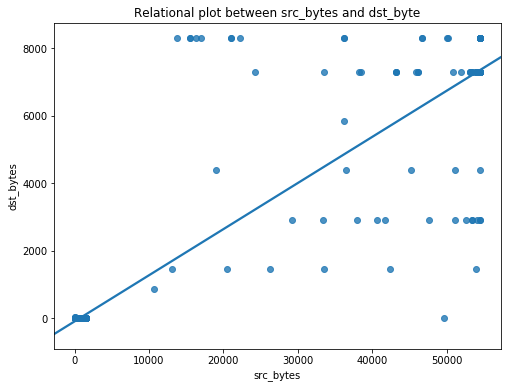

In [10]:
fig=plt.figure(figsize=(8,6))
src_dos=train_df2[train_df2['attack_type']=='DOS']['src_bytes']
dst_dos=train_df2[train_df2['attack_type']=='DOS']['dst_bytes']
sns.regplot(src_dos, dst_dos)
plt.title("Relational plot between src_bytes and dst_byte: DOS", fontsize=20)
plt.show()

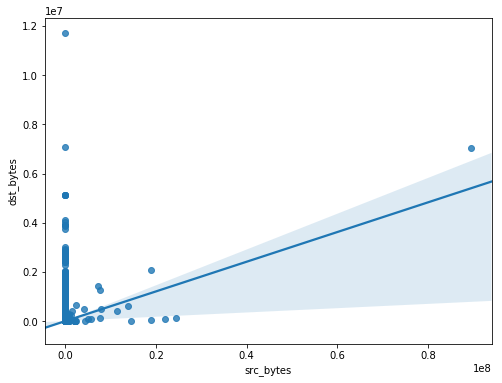

In [9]:
fig=plt.figure(figsize=(8,6))
src_sfe=train_df2[train_df2['attack_type']=='safe']['src_bytes']
dst_sfe=train_df2[train_df2['attack_type']=='safe']['dst_bytes']
sns.regplot(src_sfe, dst_sfe)
plt.title("Relational plot between src_bytes and dst_byte: DOS", fontsize=20)
plt.show()

When we compare relational plot between ```src_byte``` and ```dst_byte``` we see there is an interesting pattern where ```src_byte``` increase shows corresponding increase in ```dst_byte``` for DOS traffic. In case of safe traffic when we see increase in ```src_bytes``` but ```dst_bytes``` remain around zero this  could indicate some kind of upload operation example ``ftp put``  similarly when we see ```dst_bytes``` but ```src_bytes``` remain around zero this  could indicate some kind of down load or simple web browsing example ```HTTP GET```. We would like to explore this interesting pattern but before we proceed we want to take care of outlier

#### Identifying outlier 

In [12]:
max(train_df2[train_df2['attack_type']=='safe']['src_bytes'])

89581520

In [13]:
train_df2[(train_df2['attack_type']=='safe') & (train_df2['src_bytes']==89581520)]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,count,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
3385617,5158,tcp,X11,SF,89581520,7028652,0,0,0,1,...,11,0.04,0.03,0.01,0.0,0.0,0.0,0.0,0.0,safe


We will remove the above observation to see if the outlier gets removed

In [15]:
train_df2.drop(train_df2.index[3385617], inplace=True)

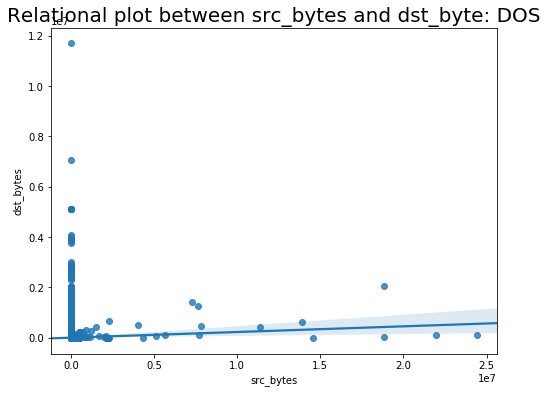

In [16]:
fig=plt.figure(figsize=(8,6))
src_sfe=train_df2[train_df2['attack_type']=='safe']['src_bytes']
dst_sfe=train_df2[train_df2['attack_type']=='safe']['dst_bytes']
sns.regplot(src_sfe, dst_sfe)
plt.title("Relational plot between src_bytes and dst_byte: DOS", fontsize=20)
plt.show()

We see the outlier got eliminated. Now we want to explore ```src_byes``

In [109]:
X_bytes=pd.DataFrame()
X_bytes['abs_bytes_diff']=np.abs(train_df2['src_bytes']-train_df2['dst_bytes'])
X_bytes['bytes_diff']=train_df2['dst_bytes']-train_df2['src_bytes']
X_bytes['attack_type']=train_df2['attack_type']
X_bytes['duration']=train_df2['duration']

### Distribution of source and destination bytes difference

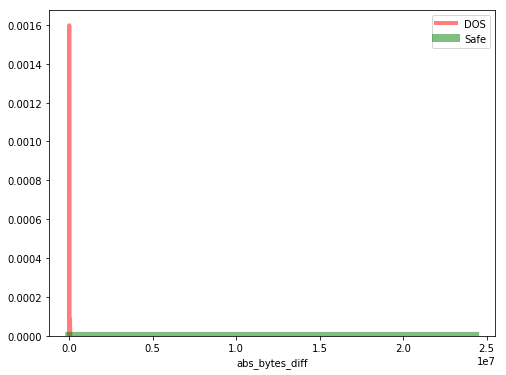

In [21]:
fig=plt.figure(figsize=(8,6))
sns.distplot(X_bytes[X_bytes['attack_type']=='DOS']['abs_bytes_diff'], 
            kde_kws={"color":"r","lw":4,"label":"KDE Estim","alpha":0.5}
             , label='DOS', hist=False)
sns.distplot(X_bytes[X_bytes['attack_type']=='safe']['abs_bytes_diff'],
            kde_kws={"color":"g","lw":8,"label":"KDE Estim","alpha":0.5},
             label='Safe', hist=False,)
plt.legend()
plt.show()

We see the distribution of difference ```src_bytes``` and ```dst_bytes```  are very different and we would like to use it as a feature

### Distribution of DOS and normal traffic duration difference

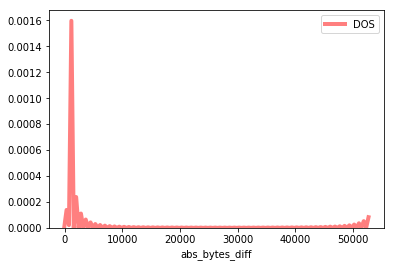

In [22]:
sns.distplot(X_bytes[X_bytes['attack_type']=='DOS']['abs_bytes_diff'], 
            kde_kws={"color":"r","lw":4,"label":"KDE Estim","alpha":0.5}
             , label='DOS', hist=False)

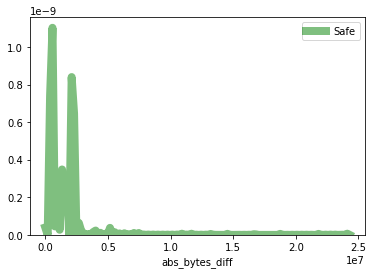

In [24]:
sns.distplot(X_bytes[X_bytes['attack_type']=='safe']['abs_bytes_diff'],
            kde_kws={"color":"g","lw":8,"label":"KDE Estim","alpha":0.5},
             label='Safe', hist=False,)

### One hot encoding

In [25]:

prt_dummy=pd.get_dummies(train_df2['protocol_type'])
srv_dummy=pd.get_dummies(train_df2['service'])
flag_dummy=pd.get_dummies(train_df2['flag'])

As rule of hot encoding we have to  eliminate at least one feature that came from hot encoding.
Our strategy would be to eliminate where number of ```1's``` is less than 1%.   

In [27]:
# Function to identify columns to with 1's is less than 1%.
def reduce_hotencode_sparcity(df, pct_allowed, indx=0):
    return [i for i in df.columns if 
            df[i].value_counts(normalize=True)[indx]*100<pct_allowed]

In [28]:
k=reduce_hotencode_sparcity(srv_dummy, pct_allowed=1, indx=1 )
l=reduce_hotencode_sparcity(flag_dummy, pct_allowed=1, indx=1 )

### Concatinating and reducing dimension for one hot encode

In [29]:
prt_dummy.drop(columns=['udp'], inplace=True)
srv_dummy.drop(columns=k, inplace=True)
flag_dummy.drop(columns=l, inplace=True)
train_df2=pd.concat([train_df2,prt_dummy], axis=1 )
train_df2=pd.concat([train_df2,srv_dummy], axis=1 )
train_df2=pd.concat([train_df2,flag_dummy], axis=1 )
train_df2.shape

(4856150, 40)

In [30]:
train_df2.drop(columns=['protocol_type', 'service', 'flag'], inplace=True)

 ### Getting all independent variables

In [31]:

X2b=train_df2.drop(columns=['attack_type'])

### Getting list of continuous variables 

In [32]:
cont_columns= ['duration', 'src_bytes', 'dst_bytes', 'count', 'wrong_fragment', 'urgent',
              'srv_count', 'serror_rate', 'srv_serror_rate','rerror_rate' ,'srv_rerror_rate',
              'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
              'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
              'dst_host_serror_rate','dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

### Creating 2 data frames , continuous and discrete

In [76]:
X_cont=X2b[cont_columns]
X_disc=X2b.drop(columns=cont_columns)

### Checking the linear relation among continuous  features
** Challenges **

All features do not have linear relation.

Exploratory data analysis suggest that there are features which shows no linear relation but are important to help in distinguishing normal traffic from Denial of Service

Principle component analysis assumes features has linear relation.

** Strategies to overcome challenges **

Using Kernel based PCA. Disadvantage to the approach is that Kernel PCA demands high resource utilization resulting in ```Memory Error```

Using domain knowledge we identified set of features  that may be related and see if there are linear relation between them.

Connection features can be divided into 3 subsets 

1) TCP packets headers

2) Errors

3) Packet size and connection duration

During Exploratory Data Analysis we discovered that
Safe packets either has high destination packet size OR high source packet size but never both
Malicious packets may have high destination packet size AND high source packet size and they may occur simultaneously. We will use absolute difference in source packets and destination packets as a a feature. This will also help us to reduce or dimensions 


In [77]:
def corr_plot(df):
    # Set the default matplotlib figure size to 7x7:
    fix, ax = plt.subplots(figsize=(12,10))

   # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(df.corr(), mask=mask, ax=ax, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

In [78]:
X2bc1=X2b[['duration', 'serror_rate', 'srv_serror_rate','rerror_rate' , 'srv_rerror_rate']]


In [79]:
X2bc1[:50000].corr()

,duration,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate
duration,1.000000,-0.001042,-0.001075,0.074076,0.074076
serror_rate,-0.001042,1.000000,0.895523,-0.002250,-0.002250
srv_serror_rate,-0.001075,0.895523,1.000000,-0.002324,-0.002324
rerror_rate,0.074076,-0.002250,-0.002324,1.000000,1.000000
srv_rerror_rate,0.074076,-0.002250,-0.002324,1.000000,1.000000


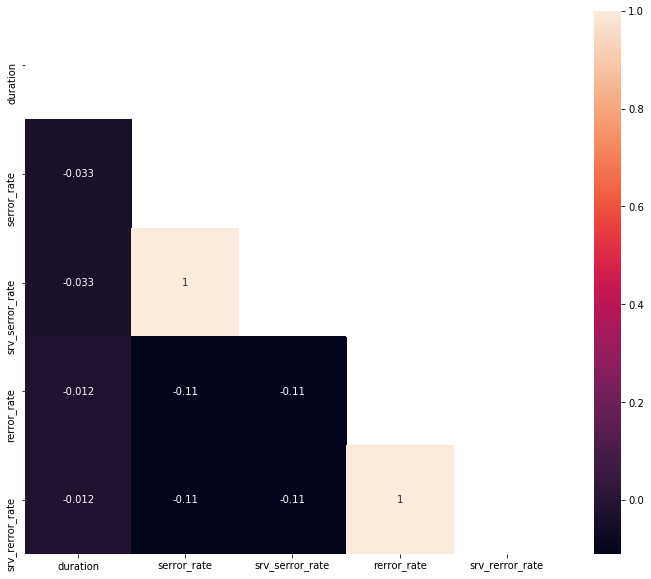

In [80]:
corr_plot(X2bc1)

We see very high correlation between ```srv_serror_rate``` and ```rerror_rate```

In [68]:
X2bc2=X2b[['dst_host_serror_rate','dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
           'dst_host_srv_rerror_rate' , 'srv_rerror_rate', 'srv_serror_rate' ]]

In [69]:
X2bc2[:50000].corr()

,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,srv_rerror_rate,srv_serror_rate
dst_host_serror_rate,1.000000,0.101734,-0.003847,-0.003807,-0.003756,0.411127
dst_host_srv_serror_rate,0.101734,1.000000,-0.000926,-0.003154,-0.003112,0.241525
dst_host_rerror_rate,-0.003847,-0.000926,1.000000,0.997684,0.994398,-0.002381
dst_host_srv_rerror_rate,-0.003807,-0.003154,0.997684,1.000000,0.996506,-0.002356
srv_rerror_rate,-0.003756,-0.003112,0.994398,0.996506,1.000000,-0.002324
srv_serror_rate,0.411127,0.241525,-0.002381,-0.002356,-0.002324,1.000000


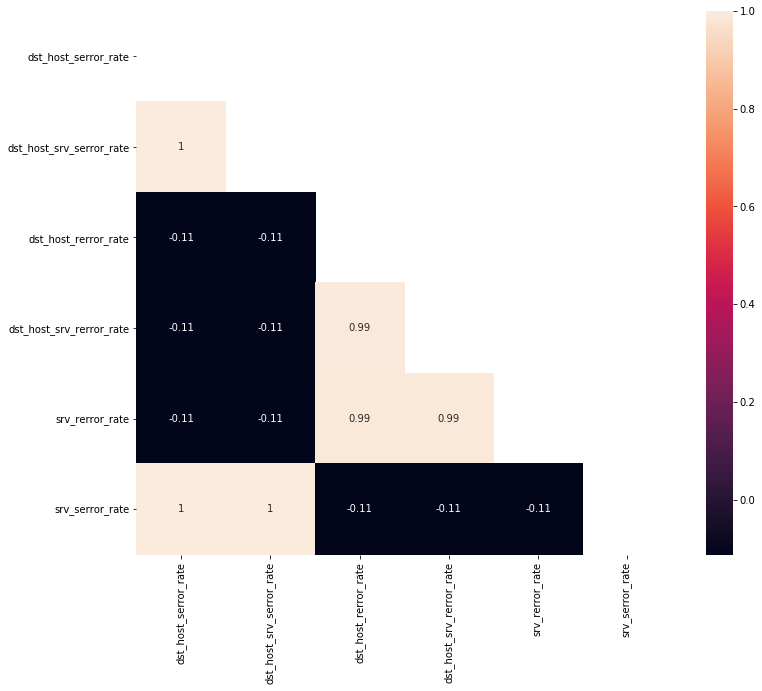

In [70]:
corr_plot(X2bc2)

In [71]:
X2bc3=X2b[['same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate','dst_host_count',
          'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
          'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate','serror_rate',
          'srv_rerror_rate', 'count']]

In [72]:
X2bc3.corr()

,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,serror_rate,srv_rerror_rate,count
same_srv_rate,1.000000,-0.481625,0.101984,-0.176605,0.914116,0.936554,-0.280476,0.666980,0.102856,-0.865958,-0.325451,0.376942
diff_srv_rate,-0.481625,1.000000,-0.015554,0.054282,-0.480732,-0.487521,0.342962,-0.312824,-0.028701,0.354736,0.133144,-0.271563
srv_diff_host_rate,0.101984,-0.015554,1.000000,-0.361488,0.006516,0.039592,0.006792,-0.210487,0.198342,-0.090991,0.034245,-0.311524
dst_host_count,-0.176605,0.054282,-0.361488,1.000000,-0.043419,-0.120151,0.018771,0.313851,-0.592416,0.154977,-0.100242,0.531681
dst_host_srv_count,0.914116,-0.480732,0.006516,-0.043419,1.000000,0.980864,-0.494506,0.690670,0.011694,-0.793928,-0.313704,0.518642
dst_host_same_srv_rate,0.936554,-0.487521,0.039592,-0.120151,0.980864,1.000000,-0.497613,0.679940,0.062670,-0.813613,-0.301069,0.482571
dst_host_diff_srv_rate,-0.280476,0.342962,0.006792,0.018771,-0.494506,-0.497613,1.000000,-0.172721,-0.021161,0.212275,0.081111,-0.325482
dst_host_same_src_port_rate,0.666980,-0.312824,-0.210487,0.313851,0.690670,0.679940,-0.172721,1.000000,-0.166464,-0.587311,-0.270116,0.881693
dst_host_srv_diff_host_rate,0.102856,-0.028701,0.198342,-0.592416,0.011694,0.062670,-0.021161,-0.166464,1.000000,-0.090078,0.240199,-0.309250
serror_rate,-0.865958,0.354736,-0.090991,0.154977,-0.793928,-0.813613,0.212275,-0.587311,-0.090078,1.000000,-0.111205,-0.325100


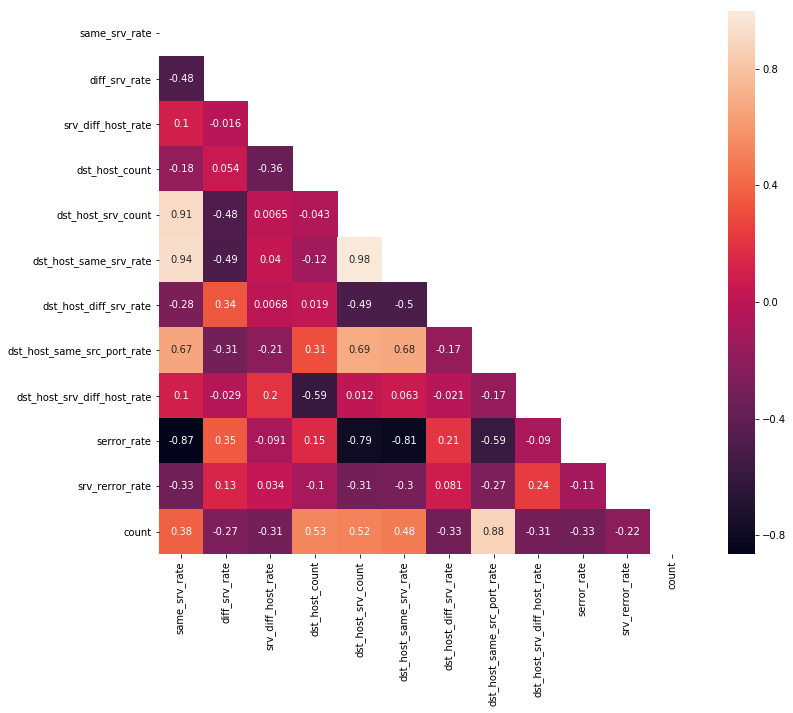

In [73]:
corr_plot(X2bc3)

### Checking the linear relation among discrete  features including one hot encoding

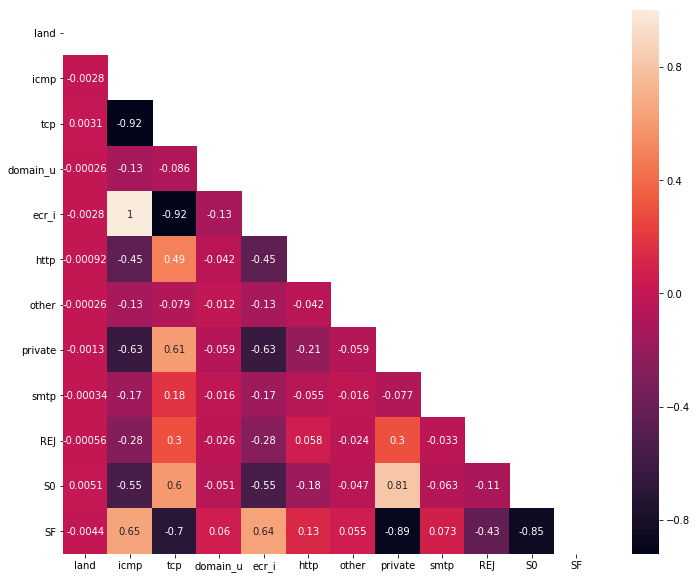

In [50]:
corr_plot(X_disc)

In [82]:
X_disc.drop(columns=['land'], inplace=True)

## Dimensionality reduction using Principle Component Analysis

In [52]:
X2b_cont1=X2b[['same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate','dst_host_count',
          'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
          'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate','serror_rate', 
          'srv_serror_rate','rerror_rate' , 'srv_rerror_rate','dst_host_serror_rate',
          'dst_host_srv_serror_rate','dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
           'count']]

In [53]:
SS=StandardScaler()
X2b_cont1_SS=SS.fit(X2b_cont1)
X2b_cont1SS=X2b_cont1_SS.transform(X2b_cont1)

In [54]:
# Running PCA across all 10 features in set 
pca = PCA(n_components=10)
pca_fit = pca.fit(X2b_cont1SS)

print(pca_fit.explained_variance_)
print(pca_fit.components_)

[7.54103733 4.47521177 2.21761588 1.1568165  0.8250984  0.66737048
 0.62555108 0.28360334 0.10812196 0.04064232]
[[-3.50435400e-01  1.85181569e-01 -6.58667698e-03  1.54917301e-02
  -3.47866208e-01 -3.50713942e-01  1.42212061e-01 -2.80364752e-01
   6.59546781e-04  3.25110902e-01  3.25104144e-01  9.49357711e-02
   9.49324291e-02  3.25191149e-01  3.25156093e-01  9.51140274e-02
   9.52675288e-02 -2.01906052e-01]
 [-1.20793868e-02  1.57506466e-02  7.71407458e-02 -1.48978607e-01
  -3.53822941e-02 -2.07146122e-02  2.06522833e-02 -8.47194097e-02
   1.87045997e-01 -1.86288619e-01 -1.86266994e-01  4.40016449e-01
   4.39683826e-01 -1.86248188e-01 -1.86326420e-01  4.40278387e-01
   4.39457803e-01 -1.20333942e-01]
 [ 1.33454803e-01 -3.42617727e-02  3.91099648e-01 -5.52906174e-01
   2.73236882e-02  6.84110917e-02  1.61107386e-02 -2.88327413e-01
   3.81441831e-01 -1.31729909e-02 -1.29361477e-02 -1.53059910e-01
  -1.53236542e-01 -1.28946872e-02 -1.36078579e-02 -1.49613013e-01
  -1.51272008e-01 -4.4177

In [55]:
var_exp = pca_fit.explained_variance_ratio_
print('Explained variance:            ', var_exp)

cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [0.41894643 0.24862282 0.12320086 0.06426757 0.04583879 0.03707613
 0.03475283 0.01575574 0.00600677 0.00225791]
Cumulative explained variance:  [0.41894643 0.66756926 0.79077011 0.85503768 0.90087647 0.93795261
 0.97270544 0.98846117 0.99446795 0.99672585]


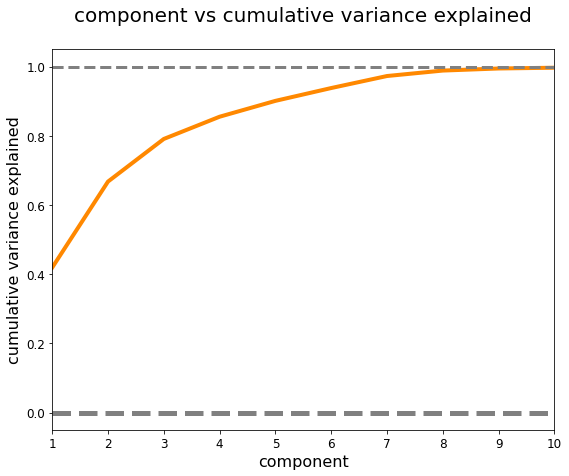

In [56]:
plt.figure(figsize=(9,7))

# HERE IS THE BASIC PLOT

# Plot the cumulative explained variance
component_number = [1,2,3,4,5,6,7,8,9,10]
plt.plot(component_number, cum_var_exp, lw=4, color='#ff8800')

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,10])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

Above plot shows that 8 out of 10 principle components captures the variation of the the selected 10 features

In [57]:
pca = PCA(n_components=8)
X2b_cont1SS_pca = pca.fit_transform(X2b_cont1SS)


In [83]:

SS1=StandardScaler()
X2b_discSS1=SS1.fit_transform(X_disc)

In [84]:
pca = PCA()
pca_fit1 = pca.fit(X2b_discSS1)

print(pca_fit1.explained_variance_)
print(pca_fit1.components_)

[4.79851795e+00 1.76132018e+00 1.12020364e+00 1.05731326e+00
 1.01202199e+00 1.00145316e+00 1.63963132e-01 5.62511322e-02
 2.18392209e-02 3.70255238e-03 3.41605396e-03]
[[-4.20997485e-01  4.22212673e-01 -4.27742270e-04 -4.20030118e-01
   1.05757171e-01  1.28435539e-03  3.82410230e-01  3.31253650e-02
   1.61283448e-01  3.48569516e-01 -4.02539355e-01]
 [-2.50548886e-01  2.16863777e-01  9.35789963e-02 -2.50680643e-01
   6.45778341e-01  9.11672278e-02 -3.48740030e-01  2.04688723e-01
   4.30222409e-02 -3.65094349e-01  3.07562249e-01]
 [-1.25346667e-01 -5.40551129e-02  3.94217251e-01 -1.25734350e-01
  -2.10820893e-01  3.86565281e-01 -2.96967327e-02  3.98498616e-01
  -6.22623068e-01  2.37536470e-01  1.11828541e-01]
 [-7.10672913e-02 -1.70855001e-01  5.43338399e-01 -7.13169947e-02
  -5.85778743e-02  5.18785551e-01  2.86647195e-02 -5.00428959e-01
   3.43419870e-01 -1.46320304e-01 -4.78311267e-02]
 [-3.64118529e-05  4.76885509e-04 -6.96168574e-01 -3.65520115e-05
   6.96219271e-03  7.17457383e-01

In [85]:
var_exp = pca_fit1.explained_variance_ratio_
print('Explained variance:            ', var_exp)

cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [4.36228815e-01 1.60119983e-01 1.01836673e-01 9.61193676e-02
 9.20019804e-02 9.10411777e-02 1.49057362e-02 5.11373824e-03
 1.98538331e-03 3.36595601e-04 3.10550296e-04]
Cumulative explained variance:  [0.43622881 0.5963488  0.69818547 0.79430484 0.88630682 0.977348
 0.99225373 0.99736747 0.99935285 0.99968945 1.        ]


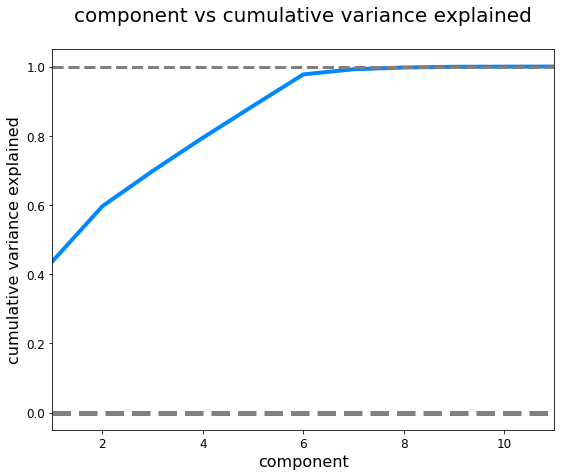

In [87]:
plt.figure(figsize=(9,7))
# Plot the cumulative explained variance
component_number = [1,2,3,4,5,6,7,8,9,10, 11]
plt.plot(component_number, cum_var_exp, lw=4, color='#0088ff')

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,11])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

Above plot shows that 7 out of 11 principle components captures the variation of the the selected 11 features

In [88]:
pca = PCA(n_components=7)
X2b_disc_pca = pca.fit_transform(X_disc)



In [119]:
X1=pd.DataFrame()
X1['abs_bytes_diff']=X_bytes['abs_bytes_diff']
X1['duartion']=train_df2['duration']

In [120]:
X_bytes.head()

,abs_bytes_diff,bytes_diff,attack_type,duration
0,44861,44861,safe,0
1,4366,4366,safe,0
2,992,992,safe,0
3,1799,1799,safe,0
4,247,247,safe,0


In [121]:
mms=MinMaxScaler(feature_range=(-9,26 ))
X1_mms=mms.fit_transform(X1)

In [122]:
X=np.concatenate((X2b_disc_pca,X2b_cont1SS_pca, X1_mms), axis=1 )

## Anomaly Detection using Gaussian Mixture Model 

In [128]:
clf = mixture.GaussianMixture(n_components=2, covariance_type='full', max_iter=1000, 
                              init_params='random', warm_start=True)
clf.fit(X)

GaussianMixture(covariance_type='full', init_params='random', max_iter=1000,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=True, weights_init=None)

In [129]:
gm=clf.predict(X)

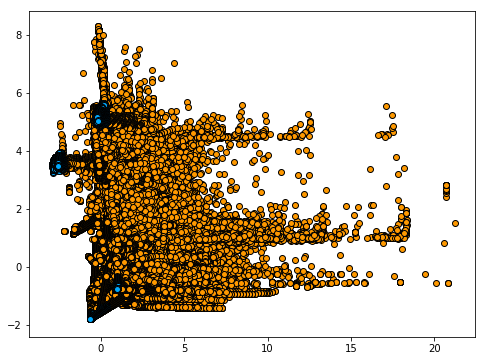

In [130]:
plt.figure(figsize=(8,6))
plt.scatter(X[gm==0, 9], X[gm==0, 7], color='#ff9900', marker='o',edgecolors='k')
plt.scatter(X[gm==1, 9], X[gm==1, 7], color='#00aaff', marker='o', edgecolors='k')

plt.show()

In [131]:
X_bytes['label1']=gm

In [132]:
X_bytes[X_bytes['attack_type']=='DOS']['label1'].value_counts(normalize='True')

1    0.978307
0    0.021693
Name: label1, dtype: float64

In [133]:
X_bytes[X_bytes['attack_type']=='safe']['label1'].value_counts(normalize='True')

0    0.814871
1    0.185129
Name: label1, dtype: float64

Gaussian Mixture Model has labeled 97.8% of the DOS session as 1 (Orange) while 81.47% 0 (blue)

## Storing the feature engineered data 

In [123]:
cols=[str(i) for i in range(17)]

In [124]:
X_yML=pd.DataFrame(X, columns=cols)

In [125]:
X_yML['attack_code']=X_bytes['attack_type'].map(lambda x: 1 if x=='DOS' else 0)

In [137]:
X_yML.fillna(0, inplace=True)

In [140]:
X_yML.to_csv('./Data/trainML.csv', index=False)